In [1]:
import numpy as np
from matplotlib import pyplot as plt
from src.experimental import ElifeData, plot_formatted_elife_data
from syd import make_viewer

In [2]:
data = ElifeData()
all_keys = list(data._data[0].keys())
for cell in data._data:
    if set(all_keys) != set(cell.keys()):
        print(cell["cellid"], list(cell.keys()))
print(all_keys)

['date', 'cellid', 'internal', 'calcium', 'distance', 'pap', 'dap', 'sap', 'pglu', 'dglu', 'sglu', 'pgap', 'dgap', 'sgap', 'ssyn', 'dpk', 'spk', 'dbase', 'sbase', 'name']


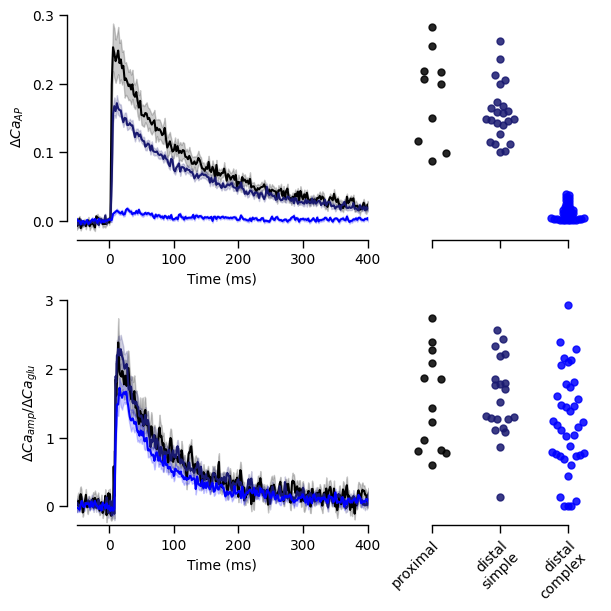

In [5]:
fig = plot_formatted_elife_data(data, show_error=True, se=True, show_fig=True, save_fig=False)

In [112]:
def plot(state):
    def correct_pmt(x):
        x[98:101] = np.mean(x[60:98]) * np.random.randn(3)
        return x
    
    icell = state["cell"]
    c_ap = data.sapbase[:, icell]
    c_glu = correct_pmt(data.sglubase[:, icell])
    c_gap = correct_pmt(data.sgapbase[:, icell])
    c_syn = data.syntrace[:, icell]

    c_ap_peak = data.spk_new[data.idx_ap, icell]
    c_glu_peak = data.spk_new[data.idx_glu, icell]
    c_gap_peak = data.spk_new[data.idx_gap, icell]
    c_nl = c_gap_peak - c_ap_peak - c_glu_peak
    
    start_pos = state["start_pos"]
    delta_pos = state["delta_pos"]

    start_offset = 67
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.axhline(0, color="black", linewidth=0.7)

    ax.plot(data.tvec[start_offset:] - 100, c_ap[start_offset:], color="black", linewidth=1.0)
    ax.plot(data.tvec[start_offset:] - 100, c_glu[start_offset:], color="red", linewidth=1.0)
    ax.plot(data.tvec[start_offset:] - 100, c_gap[start_offset:], color="darkorange", linewidth=1.0)
    ax.plot(data.tvec[start_offset:] - 100, c_syn[start_offset:], color="black", linewidth=1.0)
    ax.plot(data.tvec[start_offset:] - 100, c_syn[start_offset:], color="red", linestyle="--", linewidth=1.0)
    ax.plot([0, 0], [-0.09, -0.04], color="black", linewidth=1.5, linestyle="-")

    def stem(x, y, ystart=0, color="black", linewidth=2.0):
        ax.plot([x, x], [ystart, y], color=color, linewidth=linewidth)
        ax.plot(x, y, color=color, marker="o", markersize=4, markeredgecolor=color, markerfacecolor=color)

    start_ap = start_pos - 100
    start_glu = start_ap + delta_pos
    start_gap = start_ap + 2 * delta_pos
    start_syn = start_ap + 3 * delta_pos
    stem(start_ap, c_ap_peak, color="black")
    stem(start_glu, c_glu_peak, color="red")
    stem(start_gap, c_gap_peak, color="darkorange")
    stem(start_syn, c_ap_peak + c_glu_peak + c_nl, ystart=c_ap_peak + c_glu_peak, color="blue")
    stem(start_syn, c_ap_peak + c_glu_peak, ystart=c_ap_peak, color="red")
    stem(start_syn, c_ap_peak, color="black")
    
    # Create legends and scale bars
    scale_x_root = 200
    scale_x_mag = 50
    scale_y_root = 0.3
    scale_y_mag = 0.07
    scale_y_offset = 0.01
    
    ax.plot([scale_x_root, scale_x_root], [scale_y_root, scale_y_root + scale_y_mag], color="black", linewidth=1.0)
    ax.plot([scale_x_root, scale_x_root + scale_x_mag], [scale_y_root, scale_y_root], color="black", linewidth=1.0)
    ax.text(scale_x_root, scale_y_root - scale_y_offset, f"{scale_x_mag}ms", ha="left", va="top", fontsize=12)
    ax.text(scale_x_root, scale_y_root, f"{int(scale_y_mag*100)}% $\Delta$ G/R", ha="right", va="bottom", rotation=90, fontsize=12)

    names = ["$\Delta Ca_{amp}$", "$\Delta Ca_{1 AP}$", "$\Delta Ca_{Glu}$", "$\Delta Ca_{pairing}$"]
    colors = ["blue", "black", "red", "darkorange"]
    legend_x_start = 260
    legend_y_start = 0.72
    legend_y_offset = -0.065

    for i, (name, color) in enumerate(zip(names, colors)):
        xpos = legend_x_start
        ypos = legend_y_start + i * legend_y_offset
        ax.text(xpos, ypos, name, ha="left", va="center", fontsize=16, color=color)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_xlim(-100, 400)
    ax.set_ylim(-0.11, 0.79)

    return fig


viewer = make_viewer(plot)
viewer.add_integer("cell", value=17, min_value=0, max_value=data.NR - 1)
viewer.add_integer("start_pos", value=20, min_value=0, max_value=100)
viewer.add_float("delta_pos", value=10.0, min_value=0, max_value=20.0, step=0.5)
viewer = viewer.deploy(env="notebook")

In [6]:
ptv = np.arange(0.1, 1000.1, 0.1)

def plot(state):
    icell = state["cell"]
    site = state["site"]
    stim = state["stim"]
    target = f"{site}{stim}"
    cdata = data._data[icell][target]

    xvals = np.arange(0.1, 1000.1, 0.1) if site=="p" else np.arange(1, 513)
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.plot(xvals, cdata)
    return fig

plt.close("all")
checkout_data = False
if checkout_data:
    viewer = make_viewer(plot)
    viewer.add_integer("cell", value=0, min_value=0, max_value=data.NR - 1)
    viewer.add_selection("site", value="p", options=["p", "d", "s"])
    viewer.add_selection("stim", value="ap", options=["ap", "glu", "gap"])
    viewer.deploy(env="notebook")

1.4960629921259843 1.4960629921259843


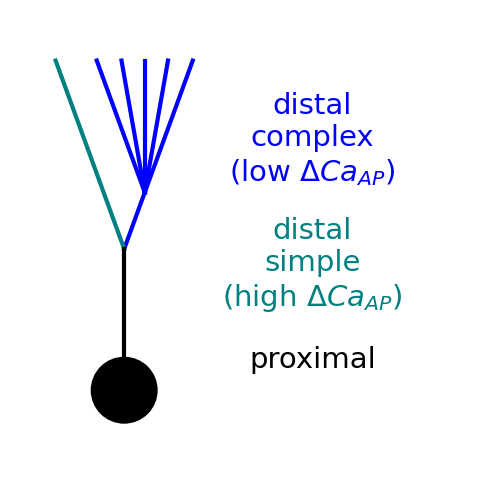

In [1]:
import matplotlib.pyplot as plt
from src.plotting import FigParams, save_figure, Proximal, DistalSimple, DistalComplex
from src.files import get_figure_dir
from src.schematics import Neuron

fig_width = FigParams.onepointfive_width / 3
fig_height = fig_width
print(fig_width, fig_height)
fig, ax = plt.subplots(figsize=(fig_width, fig_height), **FigParams.all_fig_params())
neuron = Neuron(soma_filled=True, linewidth=1.0)
elements = neuron.plot(ax, origin=(0, 0), scale=1.0)
ax.set_xticks([])
ax.set_yticks([])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ylim = (-1.0, 5.75)
yrange = ylim[1] - ylim[0]
xrange = fig_width / fig_height * yrange
xstart = -1.5
xend = xstart + xrange
ax.set_xlim(xstart, xend)
ax.set_ylim(*ylim)
ax.set_aspect("equal")
y_proximal = 0.5
y_distal_simple = 2.0
y_distal_complex = 4.0
ax.text(3.0, y_proximal, Proximal.label, color=Proximal.color, ha="center", va="center", fontsize=7)
ax.text(3.0, y_distal_simple, DistalSimple.labelnl + "\n(high $\Delta Ca_{AP}$)", color=DistalSimple.color, ha="center", va="center", fontsize=7)
ax.text(3.0, y_distal_complex, DistalComplex.labelnl + "\n(low $\Delta Ca_{AP}$)", color=DistalComplex.color, ha="center", va="center", fontsize=7)
save_figure(fig, get_figure_dir("schematic") / "dendrite_branch_schematic_test_test")